In [13]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


### M2 EDA


📌 DF2 RAW HEAD


,통계표,계정항목,단위,변환,2003/10,2003/11,2003/12,2004/01,2004/02,2004/03,...,2025/02,2025/03,2025/04,2025/05,2025/06,2025/07,2025/08,2025/09,2025/10,2025/11
0,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)","M2(평잔,계절조정계열)",십억원,원자료,"830,331.2","843,054.4","849,773.2","854,520.6","860,954.0","868,066.8",...,"3,926,523.6","3,915,483.4","3,929,779.0","3,957,728.3","3,979,473.3","3,997,486.9","4,040,694.6","4,057,516.7","4,059,450.7","4,057,549.3"
1,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",현금통화,십억원,원자료,"17,421.9","17,628.1","16,981.0","17,927.0","16,377.8","16,625.6",...,"184,423.4","184,837.7","185,549.5","186,633.5","188,159.7","189,662.3","191,542.2","193,756.8","194,755.0","198,001.6"
2,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",요구불예금,십억원,원자료,"54,936.6","56,310.7","56,387.2","56,118.2","56,299.1","58,231.1",...,"380,647.8","382,326.5","382,893.6","380,941.8","381,536.1","388,672.6","392,552.5","397,242.5","399,650.2","397,335.6"
3,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",수시입출식저축성예금,십억원,원자료,"179,369.0","185,853.8","187,110.4","188,736.4","188,277.0","187,981.9",...,"704,311.6","701,125.4","700,175.3","705,524.4","707,358.5","713,173.2","722,292.4","726,624.3","736,198.7","737,090.5"
4,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",MMF 지분,십억원,원자료,"47,331.3","42,106.3","40,020.0","42,775.8","46,495.3","48,872.7",...,"156,790.1","152,491.6","157,167.7","163,465.9","171,090.1","168,797.0","175,874.5","177,002.2","172,162.0","171,854.4"



📌 DATE 변환 확인
NaT 개수: 0 / 266

📌 DF2 HEAD (M2만)


계정항목,date,M2
0,2004-01-01,854520.6
1,2004-02-01,860954.0
2,2004-03-01,868066.8
3,2004-04-01,870908.7
4,2004-05-01,873417.5



📌 DF2 SHAPE
(263, 2)

📌 DF2 DTYPES


,dtype
계정항목,
date,datetime64[ns]
M2,float64



📌 MISSING VALUES


,missing_count
계정항목,
date,0
M2,0



📌 DESCRIBE


count    2.630000e+02
mean     2.156561e+06
std      9.800635e+05
min      8.545206e+05
25%      1.344889e+06
50%      1.946214e+06
75%      2.908877e+06
max      4.059451e+06
Name: M2, dtype: float64


📌 BOXPLOT (M2)
Mean: 2156560.543
Q1  : 1344888.750
Q3  : 2908877.100


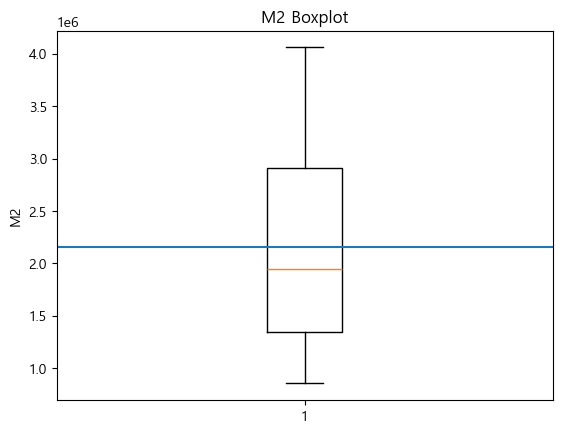

In [14]:
def section(title):
    print("\n" + "="*60)
    print(f"📌 {title}")
    print("="*60)

# ============================================================
# DF2: M2 유동성
# → "M2(평잔,계절조정계열)" 컬럼만 유지
# → 컬럼명 "M2"로 변경
# ============================================================

# 1) 로딩
df2_raw = pd.read_csv("data/M2 유동성(2003.10~).csv")
df2 = df2_raw.copy()

section("DF2 RAW HEAD")
display(df2.head())

# 2) 메타 컬럼 삭제
meta_cols = [c for c in df2.columns if any(k in str(c) for k in ["통계표", "단위", "변환"])]
df2 = df2.drop(columns=meta_cols, errors="ignore")

# 3) 첫 컬럼(항목)을 index로 설정
item_col = df2.columns[0]
df2 = df2.set_index(item_col)

# 4) 행렬 변환(전치)
df2_t = df2.T.reset_index().rename(columns={"index": "date_raw"})

# 5) 날짜 변환 (YYYY/MM → datetime)
date_str = (
    df2_t["date_raw"].astype(str).str.strip()
    .str.replace(".", "/", regex=False)
    .str.replace("-", "/", regex=False)
)
df2_t["date"] = pd.to_datetime(date_str, format="%Y/%m", errors="coerce")

section("DATE 변환 확인")
print("NaT 개수:", df2_t["date"].isna().sum(), "/", len(df2_t))

# 6) 2004-01 이후 필터
df2_t = df2_t[df2_t["date"] >= pd.Timestamp("2004-01-01")]

# 7) numeric 변환
value_cols = [c for c in df2_t.columns if c not in ["date_raw", "date"]]
for col in value_cols:
    df2_t[col] = (
        df2_t[col].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(" ", "", regex=False)
        .replace({"": np.nan, "-": np.nan, "nan": np.nan, "None": np.nan})
    )
    df2_t[col] = pd.to_numeric(df2_t[col], errors="coerce")

# 8) 최종 df2 정리 (date 첫 컬럼)
df2 = (
    df2_t.drop(columns=["date_raw"])
    .sort_values("date")
    .reset_index(drop=True)
)

df2 = df2[["date"] + [c for c in df2.columns if c != "date"]]

# ============================================================
# 9) ✅ "M2(평잔,계절조정계열)" 컬럼만 유지 + 이름 변경
# ============================================================

target_col = "M2(평잔,계절조정계열)"

if target_col not in df2.columns:
    raise ValueError("⚠️ 'M2(평잔,계절조정계열)' 컬럼이 존재하지 않습니다. 컬럼명을 확인하세요.")

df2 = df2[["date", target_col]].rename(columns={target_col: "M2"})

# ============================================================
# 10) EDA
# ============================================================

section("DF2 HEAD (M2만)")
display(df2.head())

section("DF2 SHAPE")
print(df2.shape)

section("DF2 DTYPES")
display(pd.DataFrame(df2.dtypes, columns=["dtype"]))

section("MISSING VALUES")
display(pd.DataFrame(df2.isnull().sum(), columns=["missing_count"]))

section("DESCRIBE")
display(df2["M2"].describe())

# ============================================================
# 11) 박스플롯 (M2만)
# ============================================================

section("BOXPLOT (M2)")

mean_val = df2["M2"].mean()
Q1 = df2["M2"].quantile(0.25)
Q3 = df2["M2"].quantile(0.75)

print(f"Mean: {mean_val:.3f}")
print(f"Q1  : {Q1:.3f}")
print(f"Q3  : {Q3:.3f}")

plt.figure()
plt.boxplot(df2["M2"].dropna())
plt.axhline(mean_val)
plt.title("M2 Boxplot")
plt.ylabel("M2")
plt.show()


In [15]:
# ✅ CSV 저장 (Period는 문자열로 저장하는 게 안전)
df2_to_save = df2.copy()
df2_to_save["date"] = df2_to_save["date"].astype(str)
df2_to_save.to_csv("data/전처리_M2.csv", index=False, encoding="utf-8-sig")